# Feature Engineering

Building temporal, holiday, lag, route, and weather features for route-level delay forecasting. XGBoost/LightGBM use 63 features (with explicit lags and rolling stats), LSTM/TCN use 26 (they see target history through their input sequences so lag columns would be redundant).

In [1]:
# imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.build_features import FeatureBuilder, build_features
from src.config import TRAIN_END

## Load Processed Data

In [2]:
# load processed daily route demand data
df = pd.read_csv('../data/processed/daily_route_demand.csv')
df['date'] = pd.to_datetime(df['date'])
print(f'Loaded {len(df):,} records')
df.head()

Loaded 118,650 records


,date,route,flight_count,cancelled_count,avg_dep_delay,avg_arr_delay,total_distance,carriers,cancel_rate,avg_daily_flights,...,has_adverse_weather,total_precip,total_snowfall,max_wind,peak_wind_operating,max_hourly_severity,morning_severity,evening_severity,precip_operating,storm_hours
0,2019-01-01,ANC-SEA,15,0,-5.533333,-9.466667,21720.0,"AS,DL",0.0,18.727771,...,1,2.3,1.05,32.3,32.3,4,4,2,0.7,7
1,2019-01-01,ATL-FLL,26,0,-0.423077,-6.615385,15106.0,"B6,DL,NK,WN",0.0,20.171513,...,1,13.2,0.00,25.3,25.3,3,2,2,5.8,0
2,2019-01-01,ATL-LGA,22,0,0.545455,-13.727273,16764.0,"AA,DL,F9,WN,YX",0.0,19.937210,...,1,17.2,0.00,36.7,36.7,3,2,2,5.4,0
3,2019-01-01,ATL-MCO,26,0,2.692308,-4.500000,10504.0,"B6,DL,F9,NK,WN",0.0,22.188369,...,1,12.9,0.00,18.2,11.7,3,2,2,5.5,0
4,2019-01-01,ATL-MIA,20,0,-1.350000,-6.700000,11880.0,"AA,DL,F9,YX",0.0,17.454277,...,1,14.4,0.00,23.0,23.0,3,2,2,7.0,0


## Build Features

`FeatureBuilder` does the feature construction. A few things about how it avoids leakage:

- **train_end_date parameter**: Route-level statistics (`route_delay_mean`, `route_delay_std`) are computed only on data before this date
- **Per-route lag computation**: Lags are computed separately per route to avoid cross-route contamination
- **Cyclical encodings**: Day of week and month use sine/cosine encoding for smooth periodicity

In [3]:
# build all features using FeatureBuilder
builder = FeatureBuilder(df, train_end_date=TRAIN_END)
df_features = builder.build()

print(f'Output columns: {len(df_features.columns)}')
print(f'  XGBoost/LightGBM uses 63 of these, LSTM/TCN use 26')
print(f'  Extra columns: targets, dep_delay lags (unused), weather details')
print(f'\nDataset info:')
print(f'  Rows: {len(df_features):,}')
print(f'  Date range: {df_features["date"].min()} to {df_features["date"].max()}')
print(f'  train_end_date: {TRAIN_END}')
print(f'  Route stats computed from training data only')

/Users/tisyasharma/Documents/Courses/DS4200_DataViz/flight-delay-forecasting/src/build_features.py:54: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  self.df["is_federal_holiday"] = self.df["date"].isin(US_HOLIDAYS).astype(int)


Output columns: 102
  XGBoost/LightGBM uses 63 of these, LSTM/TCN use 26
  Extra columns: targets, dep_delay lags (unused), weather details

Dataset info:
  Rows: 118,650
  Date range: 2019-01-01 00:00:00 to 2025-06-30 00:00:00
  train_end_date: 2024-01-01
  Route stats computed from training data only


## Lag Feature Correlation with Delay Target

Checking how predictive each lag horizon is. `lag_1` (yesterday) should be the strongest based on the ACF from the EDA.

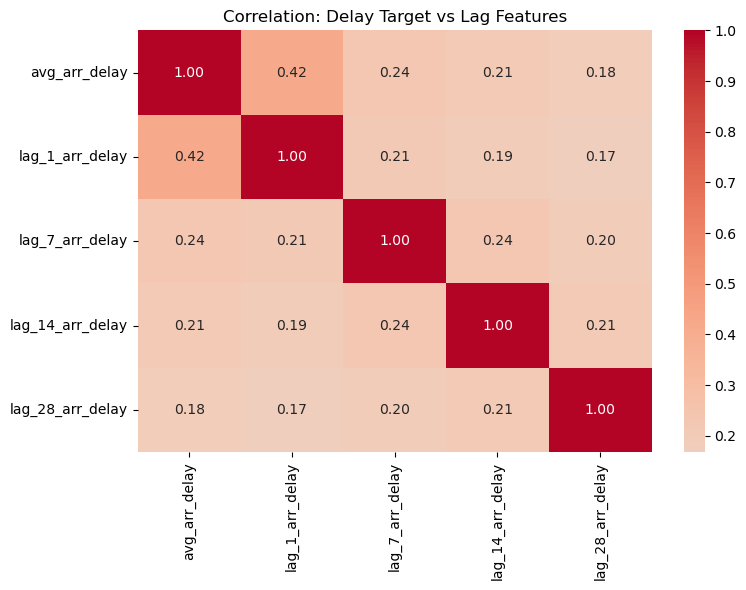

In [4]:
# correlation between delay target and lag features
lag_cols = ['avg_arr_delay', 'lag_1_arr_delay', 'lag_7_arr_delay', 'lag_14_arr_delay', 'lag_28_arr_delay']

corr_matrix = df_features[lag_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation: Delay Target vs Lag Features')
plt.tight_layout()
plt.show()

## Holiday Effects on Delays

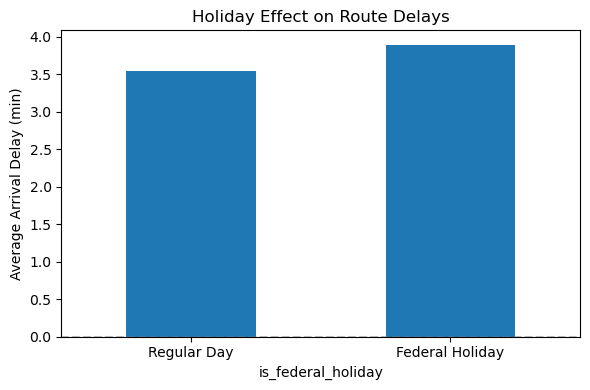

In [5]:
# compare delays on holidays vs regular days
holiday_effect = df_features.groupby('is_federal_holiday')['avg_arr_delay'].mean()

fig, ax = plt.subplots(figsize=(6, 4))
holiday_effect.plot(kind='bar', ax=ax)
ax.set_xticklabels(['Regular Day', 'Federal Holiday'], rotation=0)
ax.set_ylabel('Average Arrival Delay (min)')
ax.set_title('Holiday Effect on Route Delays')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## COVID Period Impact on Delays

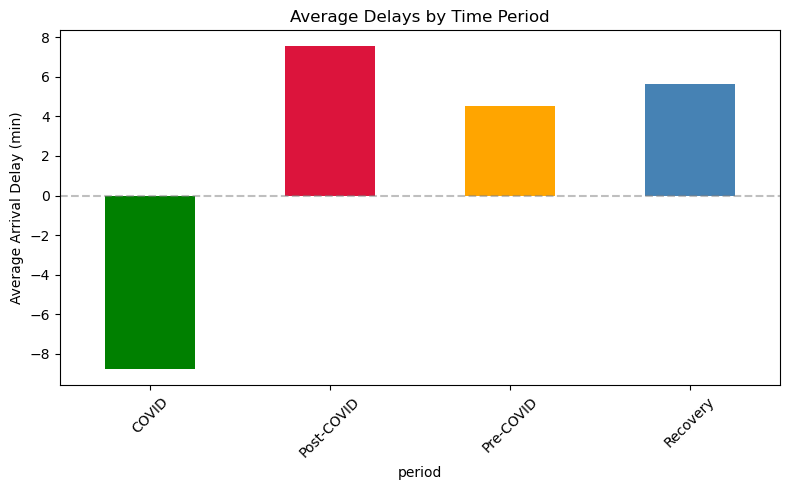

In [6]:
# compare delays across COVID time periods
viz_df = df_features.copy()
viz_df['period'] = 'Pre-COVID'
viz_df.loc[viz_df['is_covid_period'] == 1, 'period'] = 'COVID'
viz_df.loc[viz_df['is_covid_recovery'] == 1, 'period'] = 'Recovery'
viz_df.loc[viz_df['is_post_covid'] == 1, 'period'] = 'Post-COVID'

period_avg = viz_df.groupby('period')['avg_arr_delay'].mean()

fig, ax = plt.subplots(figsize=(8, 5))
period_avg.plot(kind='bar', ax=ax, color=['green', 'crimson', 'orange', 'steelblue'])
ax.set_ylabel('Average Arrival Delay (min)')
ax.set_title('Average Delays by Time Period')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Save Features

In [7]:
# save features to csv
output_path = '../data/processed/features.csv'
df_features.to_csv(output_path, index=False)
print(f'Saved features to {output_path}')
print(f'  Rows: {len(df_features):,}')
print(f'  Columns: {len(df_features.columns)}')
print(f'  Route-level stats computed with train_end_date={TRAIN_END}')

Saved features to ../data/processed/features.csv
  Rows: 118,650
  Columns: 102
  Route-level stats computed with train_end_date=2024-01-01


## Summary

XGBoost/LightGBM use 63 features, LSTM/TCN use 26. The full feature lists are defined in `src/config.py`. The 63-feature set adds lag columns (1/7/14/28 day), rolling statistics, and route metadata on top of the 26 base features. Route-level stats are computed with `train_end_date=2024-01-01` to prevent leakage.

**Next:** [03_baseline_models.ipynb](03_baseline_models.ipynb)